#### Classify 2-D D'Orsogna model simulations using persistence homology

- *Author:* Dhananjay Bhaskar
- *Last Modified:* Aug 15, 2018

In [1]:
import os
import re
import glob
import scipy
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

% matplotlib inline

from __future__ import division
init_notebook_mode(connected=True)

matplotlib.rc('axes', labelsize = 6)
matplotlib.rc('xtick', labelsize = 5) 
matplotlib.rc('ytick', labelsize = 5) 

#### Load crocker plot data (requires at least 5 GB of RAM)

In [2]:
class CP_Data:
    
    def __init__(self, icR, ilR):
        self.icR = int(icR)
        self.ilR = int(ilR)
        self.nRs = 0
        self.feats = collections.defaultdict(list)
        
    def describe(self):
        print "icR: " + repr(self.icR) + " ilR: " + repr(self.ilR) + " nRs: " + repr(self.nRs)
        
    def add_rep_feats(self, nRep, df):
        self.nRs += 1
        if nRep == self.nRs:
            self.feats[self.nRs] = df.as_matrix()
        else:
            print "Error: Replicate data entered out of order!"
    
    def get_rep_feat(self, nRep):
        return self.feats[nRep]
    
    def get_sim_params(self):
        return (self.icR, self.ilR)
    
    def get_nreps(self):
        return self.nRs

In [3]:
Crocker_Full_Data_List = list()
crocker_plot_dir = "swarm_simulations_crocker"

for subdir in glob.glob(crocker_plot_dir + "/*/"):
    
    foldername = subdir.split(os.sep)[1]
    icR = foldername.split('_')[2]
    ilR = foldername.split('_')[-1]
    Crocker_Full_Data_List.append(CP_Data(icR, ilR))
    print foldername
    
    csvfilelist = glob.glob(crocker_plot_dir + os.sep + foldername + os.sep + "*_full.csv")
    csvfilenames = [os.path.basename(csvfilename) for csvfilename in csvfilelist]
    csvfilenames.sort(key = lambda f: int(filter(str.isdigit, f)))
    
    for csvfilename in csvfilenames:
        df = pd.read_csv(crocker_plot_dir + os.sep + foldername + os.sep + csvfilename, header=None)
        re_cap = re.match(".*_iR_(\d+)(\.).*.csv", csvfilename)
        nRep = int(re_cap.group(1))
        Crocker_Full_Data_List[-1].add_rep_feats(nRep, df)
        
    Crocker_Full_Data_List[-1].describe()

data_icR_1_ilR_3
icR: 1 ilR: 3 nRs: 100
data_icR_2_ilR_3
icR: 2 ilR: 3 nRs: 100
data_icR_5_ilR_4
icR: 5 ilR: 4 nRs: 100
data_icR_4_ilR_4
icR: 4 ilR: 4 nRs: 100
data_icR_2_ilR_2
icR: 2 ilR: 2 nRs: 100
data_icR_4_ilR_1
icR: 4 ilR: 1 nRs: 100
data_icR_1_ilR_1
icR: 1 ilR: 1 nRs: 100
data_icR_1_ilR_2
icR: 1 ilR: 2 nRs: 100
data_icR_2_ilR_4
icR: 2 ilR: 4 nRs: 100
data_icR_2_ilR_1
icR: 2 ilR: 1 nRs: 100
data_icR_5_ilR_1
icR: 5 ilR: 1 nRs: 100
data_icR_3_ilR_5
icR: 3 ilR: 5 nRs: 100
data_icR_4_ilR_3
icR: 4 ilR: 3 nRs: 100
data_icR_3_ilR_3
icR: 3 ilR: 3 nRs: 100
data_icR_1_ilR_5
icR: 1 ilR: 5 nRs: 100
data_icR_4_ilR_2
icR: 4 ilR: 2 nRs: 100
data_icR_3_ilR_4
icR: 3 ilR: 4 nRs: 100
data_icR_2_ilR_5
icR: 2 ilR: 5 nRs: 100
data_icR_1_ilR_4
icR: 1 ilR: 4 nRs: 100
data_icR_5_ilR_3
icR: 5 ilR: 3 nRs: 100
data_icR_5_ilR_2
icR: 5 ilR: 2 nRs: 100
data_icR_5_ilR_5
icR: 5 ilR: 5 nRs: 100
data_icR_3_ilR_1
icR: 3 ilR: 1 nRs: 100
data_icR_4_ilR_5
icR: 4 ilR: 5 nRs: 100
data_icR_3_ilR_2
icR: 3 ilR: 2 nRs: 100


#### Extract and plot features

In [4]:
def extract_feats(CP_List, icR, ilR, nRep):
    for CP_Data in CP_List:
        if (icR, ilR) == CP_Data.get_sim_params():
            feat_data = np.transpose(CP_Data.get_rep_feat(nRep))
            feat_dict = {}
            for ind in range(len(feat_data)):
                feat_dict[str(feat_data[ind][0])] = feat_data[ind][1:]
            return feat_dict

In [43]:
feat_dict = extract_feats(Crocker_Full_Data_List, 5, 1, 3)

print feat_dict.keys()
eps_vals = list(np.unique(map(float, feat_dict['epsilon'])))
dim_vals = list(np.unique(map(int, feat_dict['dimension'])))

['epsilon', 'betticount', 'nan', 't', 'dimension']


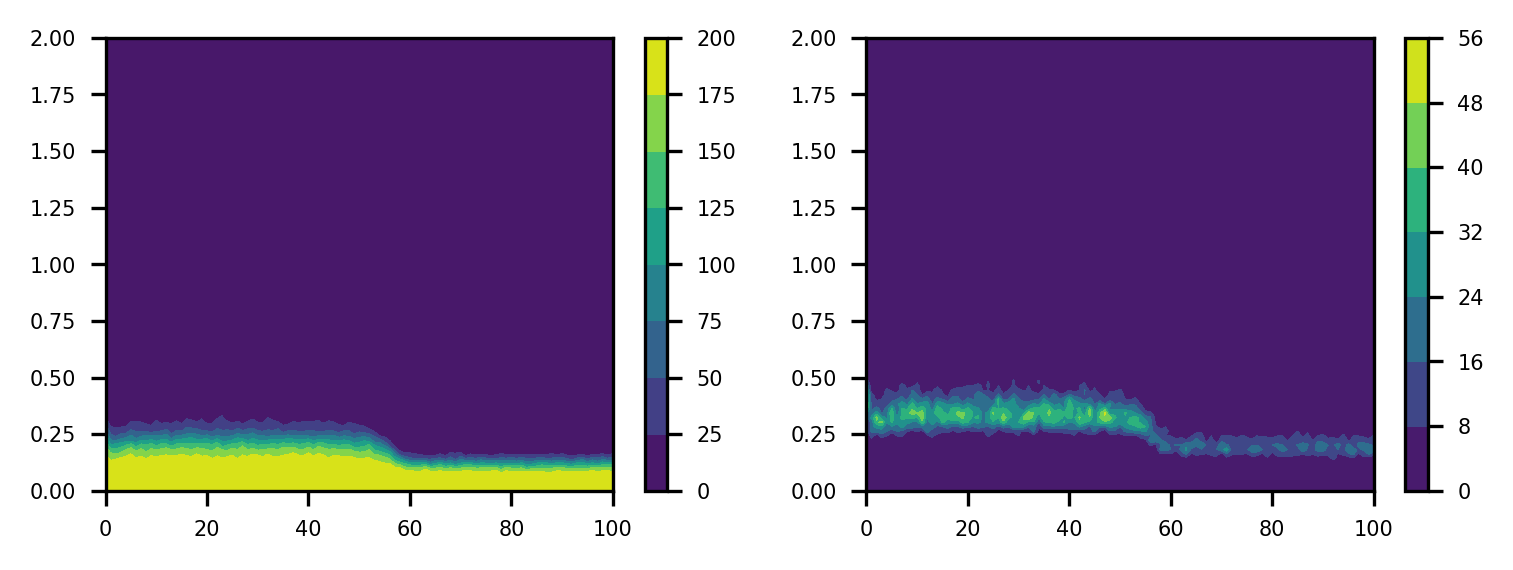

In [44]:
time_vals = np.unique(map(int, feat_dict['t']))
pers_homology = list(map(int, feat_dict['betticount']))

delta_eps = eps_vals[1] - eps_vals[0]
eps_max = int(np.max(eps_vals))
eps_min = int(np.min(eps_vals))

delta_t = time_vals[1] - time_vals[0]
t_max = int(np.max(time_vals))
t_min = int(np.min(time_vals))

betti_0_mat = np.zeros((len(time_vals), len(eps_vals)))
betti_1_mat = np.zeros((len(time_vals), len(eps_vals)))

def get_common_indices(listA, listB):
    res = list()
    for x in listA:
        if x in listB:
            res.append(x)
    return res

for t_val in time_vals:
    
    time_idx = np.where(list(map(int, feat_dict['t'])) == t_val)[0]   
    dim_0_idx = np.where(list(map(int, feat_dict['dimension'])) == dim_vals[0])[0]
    dim_1_idx = np.where(list(map(int, feat_dict['dimension'])) == dim_vals[1])[0]
    
    idx_0 = get_common_indices(time_idx, dim_0_idx)
    idx_1 = get_common_indices(time_idx, dim_1_idx)
    
    betti_0_mat[t_val, :] = [pers_homology[idx] for idx in idx_0]
    betti_1_mat[t_val, :] = [pers_homology[idx] for idx in idx_1]
    
X, Y = np.mgrid[t_min:t_max+1:delta_t, eps_min:eps_max:delta_eps]

fig, axes = plt.subplots(1, 2, figsize=(6,2), dpi=300)

c0 = axes[0].contourf(X, Y, betti_0_mat)
plt.colorbar(c0, ax=axes[0])

c1 = axes[1].contourf(X, Y, betti_1_mat)
plt.colorbar(c1, ax=axes[1])

#### Compute feature vector

In [45]:
def construct_feat_vector(CP_Data_List, icR, ilR, nRep, nSamples):
    
    feat_dict = extract_feats(CP_Data_List, icR, ilR, nRep)
    
    pers_homology = list(map(int, feat_dict['betticount']))
    
    time_vals = np.unique(map(int, feat_dict['t']))
    max_time = np.max(time_vals)
    tpoints = np.linspace(0, max_time, nSamples)
    tpoints = np.unique([int(tp) for tp in tpoints])
    
    if len(tpoints) != nSamples:
        print "Error: Number of samples requested exceed number of time points"
        return None
    
    time_idx = []
    for tp in tpoints:
        time_idx.extend(np.where(map(int, feat_dict['t']) == tp)[0])
        
    betti_feat = [pers_homology[idx] for idx in time_idx]
    
    if len(betti_feat) != nSamples * len(eps_vals) * len(dim_vals):
        print "Error: Size mismatch."
    
    return betti_feat

In [46]:
num_sims = 5*5
num_tpoints = 50
num_replicates = 100
feat_vec_size = num_tpoints * len(eps_vals) * len(dim_vals)

feat_mat = np.empty((num_sims*num_replicates, feat_vec_size))
target = np.empty((num_sims*num_replicates, 2))

ind = 0
for icR in range(1, 5+1):
    for ilR in range(1, 5+1):
        print "icR: " + repr(icR) + " ilR: " + repr(ilR)
        for rep in range(1, num_replicates+1):
            feat_mat[ind, :] = construct_feat_vector(Crocker_Full_Data_List, icR, ilR, rep, num_tpoints)
            target[ind, :] = [icR, ilR]
            ind += 1

icR: 1 ilR: 1
icR: 1 ilR: 2
icR: 1 ilR: 3
icR: 1 ilR: 4
icR: 1 ilR: 5
icR: 2 ilR: 1
icR: 2 ilR: 2
icR: 2 ilR: 3
icR: 2 ilR: 4
icR: 2 ilR: 5
icR: 3 ilR: 1
icR: 3 ilR: 2
icR: 3 ilR: 3
icR: 3 ilR: 4
icR: 3 ilR: 5
icR: 4 ilR: 1
icR: 4 ilR: 2
icR: 4 ilR: 3
icR: 4 ilR: 4
icR: 4 ilR: 5
icR: 5 ilR: 1
icR: 5 ilR: 2
icR: 5 ilR: 3
icR: 5 ilR: 4
icR: 5 ilR: 5


#### Classify features

In [47]:
scaler = StandardScaler()
print scaler.fit(feat_mat)
feat_mat_std = scaler.transform(feat_mat)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [48]:
np.save('CP_Full_standardized_features.npy', feat_mat_std)
np.save('CP_Full_targets.npy', target)

([], <a list of 0 Text yticklabel objects>)

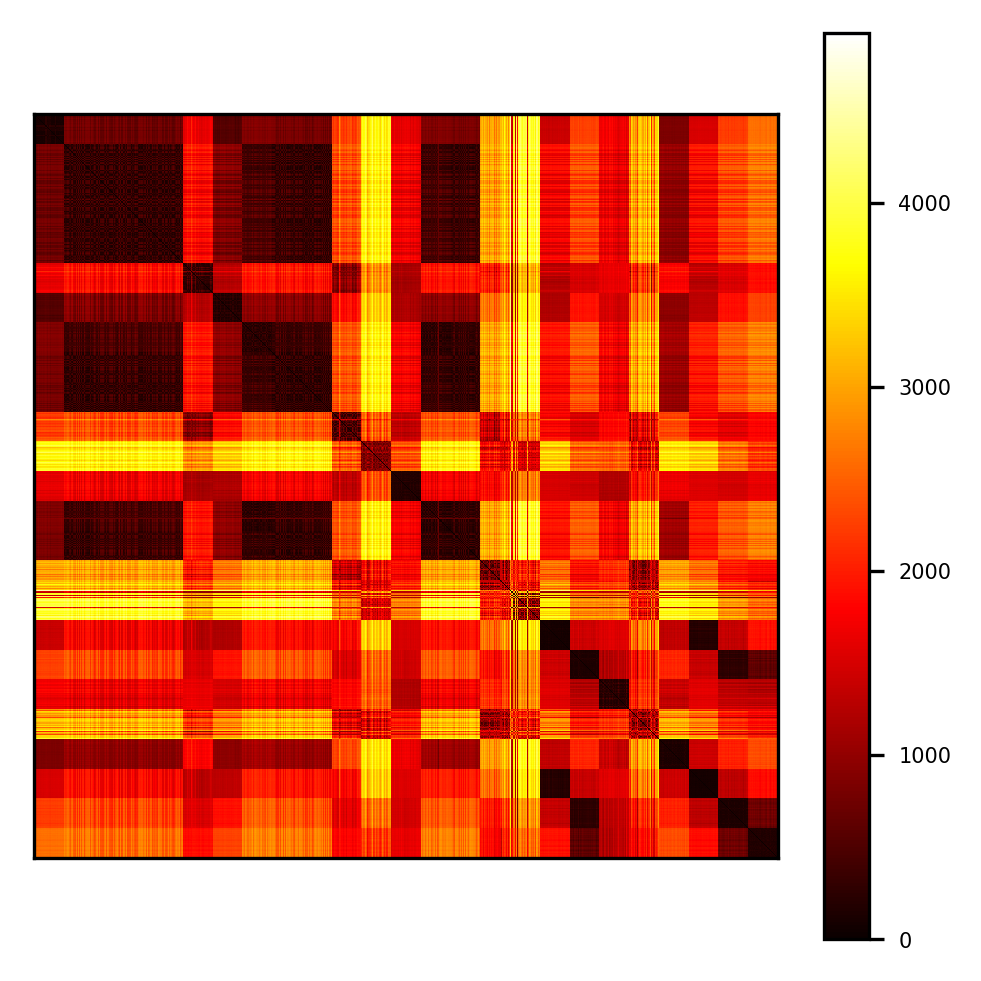

In [49]:
distances = scipy.spatial.distance.pdist(feat_mat, 'euclidean')
dist_mat = scipy.spatial.distance.squareform(distances)

plt.figure(figsize=(4,4), dpi=300)
plt.imshow(dist_mat, plt.cm.hot)
plt.colorbar()
plt.xticks([])
plt.yticks([])

#### PCA

2500
10000


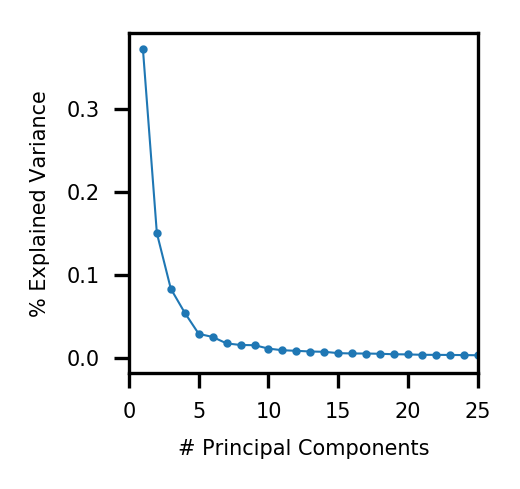

In [50]:
(num_rows, num_feat) = np.shape(feat_mat)

print num_rows
print num_feat

pca_model = PCA(n_components = num_feat)
pca_model.fit_transform(feat_mat_std)
nc = np.linspace(1, num_feat, num_feat)

plt.figure(figsize=(1.5,1.5), dpi=300)
plt.plot(nc[0:2500], pca_model.explained_variance_ratio_, '-o', markersize=1, linewidth=0.5)

plt.xlabel("# Principal Components", fontsize=5)
plt.ylabel("% Explained Variance", fontsize=5)
plt.xlim([0, 25])
plt.show()

In [51]:
pca = PCA(n_components = 3)
pca.fit(feat_mat_std)
Y = pca.transform(feat_mat_std)

plt_data = []

param_cnt = 0
for icR_val in range(1, 5+1):
    for ilR_val in range(1, 5+1):
        target_idx = list()
        cnt = 0
        for x in zip(np.array(target == [icR_val, ilR_val]).tolist()):
            if x[0] == [True, True]:
                target_idx.append(cnt)
            cnt += 1
            
        trace = go.Scatter3d(
            name = "icR: " + repr(icR_val) + " ilR: " + repr(ilR_val),
            x = Y[target_idx, 0],
            y = Y[target_idx, 1],
            z = Y[target_idx, 2],
            mode = 'markers',
            marker = dict(
                color = param_cnt,
                size = 8,
                symbol = 'circle',
                line = dict(
                    color = 'rgb(180, 180, 180)',
                    width = 1.0
                ),
                opacity = 0.4
            )
        )
        plt_data.append(trace)
        param_cnt += 1
        
layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)

#### t-SNE

In [52]:
(num_rows, num_feat) = np.shape(feat_mat_std)

tsne = TSNE(n_components=3, random_state=0, init='random', perplexity=50)
np.set_printoptions(suppress=True)
Y_tsne = tsne.fit_transform(feat_mat_std)

plt_data = []

param_cnt = 0
for icR_val in range(1, 5+1):
    for ilR_val in range(1, 5+1):
        target_idx = list()
        cnt = 0
        for x in zip(np.array(target == [icR_val, ilR_val]).tolist()):
            if x[0] == [True, True]:
                target_idx.append(cnt)
            cnt += 1
            
        trace = go.Scatter3d(
            name = "icR: " + repr(icR_val) + " ilR: " + repr(ilR_val),
            x = Y_tsne[target_idx, 0],
            y = Y_tsne[target_idx, 1],
            z = Y_tsne[target_idx, 2],
            mode = 'markers',
            marker = dict(
                color = param_cnt,
                size = 8,
                symbol = 'circle',
                line = dict(
                    color = 'rgb(180, 180, 180)',
                    width = 1.0
                ),
                opacity = 0.4
            )
        )
        plt_data.append(trace)
        param_cnt += 1
        
layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig = go.Figure(data=plt_data, layout=layout)
iplot(fig)